# Example: Comparing different compression methods for temperature (`t`) and specific humidity (`q`)

```{note}
The online laboratory has only been tested in recent Firefox and Chrome browsers. Some features may not (yet) be supported in Safari browsers.
```

```{caution}
In the online laboratory, changes to notebooks and local files are only saved in your web browser's storage and not persisted to disk.

Please download copies of any files that you don't want to loose.

Your files from an old session will usually be kept if you close or refresh this page, unless your browser's storage for `lab.climet.eu` is cleared, e.g.
- manually by clearing the browser's site data
- automatically when too much data is stored
- automatically when you close a private browsing context
- if you have setup your browser to clear site data, e.g. when the browser is closed
```

## Setting up the online laboratory

First, we import several utility packages to setup this notebook for data compression in climate science and meteorology.

Please refer back to the [01-intro.ipynb](../01-intro.ipynb) notebook for a deeper explanation.

In [1]:
import sys
sys.path.insert(0, "..")

from pathlib import Path

import dask
import fcbench
import numpy as np
import pandas as pd
import pyarrow
import xarray as xr

[pyodide]: Loaded Pint, PyYAML, asciitree, attrs, cffi, cfgrib, cftime, click, cloudpickle, dask, eccodes, field-compression-benchmark, findlibs, flexcache, flexparser, fsspec, joblib, locket, netCDF4, numcodecs, numpy, pandas, partd, platformdirs, pyarrow, pycparser, pyodide-unix-timezones, python-dateutil, pytz, scikit-learn, scipy, six, threadpoolctl, toolz, tqdm, typing_extensions, tzdata, xarray, xeofs, xhistogram, zarr
[pyodide]: Loading Jinja2, MarkupSafe
[pyodide]: Loaded Jinja2, MarkupSafe
[pyodide]: Memory usage has grown to 152.9MiB (from 49.9MiB) for this notebook
[pyodide]: Loaded 63 new dynamic libraries (69 total for this notebook)


In [2]:
import utils


fcbench.codecs.preload()

dask.config.set(array__chunk_size="4MiB");

[pyodide]: Loading msgpack
[pyodide]: Loaded msgpack
Loaded the fcbench.codecs.Asinh codec ...
Loaded the fcbench.codecs.BitRound codec ...
Loaded the fcbench.codecs.FixedOffsetScale codec ...
Loaded the fcbench.codecs.FourierNetwork codec ...
Loaded the fcbench.codecs.Identity codec ...
Loaded the fcbench.codecs.LinearQuantize codec ...
Loaded the fcbench.codecs.Log codec ...
Loaded the fcbench.codecs.RandomProjection codec ...
Loaded the fcbench.codecs.Reinterpret codec ...
Loaded the fcbench.codecs.Round codec ...
Loaded the fcbench.codecs.SwizzleReshape codec ...
Loaded the fcbench.codecs.Sz3 codec ...
Loaded the fcbench.codecs.UniformNoise codec ...
Loaded the fcbench.codecs.Zfp codec ...
Loaded the fcbench.codecs.Zlib codec ...
Loaded the fcbench.codecs.Zstd codec ...
[pyodide]: Memory usage has grown to 183.5MiB (from 152.9MiB) for this notebook
[pyodide]: Loaded 9 new dynamic libraries (78 total for this notebook)


## Retrieving and loading the dataset

First, we look at temperature and specific humidity (the percentage of the air weight that water contributes) from the global ensemble forecast dataset TIGGE, which we retrieve with the following MARS request:

```
retrieve,
dataset=tigge,
date=2024-08-02,
expver=prod,
grid=2/2,
levtype=pl,
levelist=1000,
model=glob,
origin=ecmwf,
param=130/133,
step=240,
time=00:00:00,
type=fc,
format=netcdf,
target="tigge_pl_t_q_dx=2_2024_08_02.nc"
```

The pressure level of 100hPa corresponds to an elevation of roughly 111 metres above sealevel.

In [3]:
data_path = Path("data") / "01-t-q.nc"

### Option 1: Retrieve the dataset using the `ecmwfapi`

If you have an API key from https://api.ecmwf.int/v1/key/, you can use the `ecmwfapi` to download the dataset directly from MARS by uncommenting the following code:

In [4]:
from ecmwfapi import ECMWFDataServer

if False:  # toggle to use the ecmwfapi
    server = ECMWFDataServer(**{
        "url"   : "<ECMWF-API-URL>",
        "key"   : "<ECMWF-API-KEY>",
        "email" : "<ECMWF-API-EMAIL>"
    })
    
    server.retrieve(
        {
            "dataset": "tigge",
            "date": "2024-08-02",
            "expver": "prod",
            "grid": "2/2",
            "levtype": "pl",
            "levelist": "1000",
            "model": "glob",
            "origin": "ecmwf",
            "param": "130/133",
            "step": "240",
            "time": "00:00:00",
            "type": "fc",
            "format" : "netcdf",
            "target": str(data_path),
        }
    )

[pyodide]: Loading ecmwf-api-client
[pyodide]: Loaded ecmwf-api-client


### Option 2: Download this dataset from an S3 bucket

If you cannot access the dataset with the `ecmwfapi`, you can also download it from <https://a3s.fi/compression.lab.climet.eu/tigge_pl_t_q_dx=2_2024_08_02.nc>:

In [5]:
import shutil
from urllib.request import urlopen

download_url = "https://a3s.fi/compression.lab.climet.eu/tigge_pl_t_q_dx=2_2024_08_02.nc"

if True:  # toggle to use the ecmwfapi
    with urlopen(download_url) as response:
        with data_path.open("wb") as file:
            shutil.copyfileobj(response, file)

### Options 1 & 2: Open the dataset using `xarray`

In [6]:
ds = utils.open_dataset(data_path)
ds

[pyodide]: Loading h5netcdf, h5py
[pyodide]: Loaded h5netcdf, h5py
[pyodide]: Loading future, uncertainties
[pyodide]: Loaded future, uncertainties


<xarray.Dataset> Size: 263kB
Dimensions:    (longitude: 180, latitude: 91, time: 1)
Coordinates:
  * longitude  (longitude) float32 720B 0.0 2.0 4.0 6.0 ... 354.0 356.0 358.0
  * latitude   (latitude) float32 364B 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * time       (time) datetime64[ns] 8B 2024-08-12
Data variables:
    t          (time, latitude, longitude) float64 131kB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
    q          (time, latitude, longitude) float64 131kB dask.array<chunksize=(1, 91, 180), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-09-27 11:51:26 GMT by grib_to_netcdf-2.35.3: /opt/ecmw...
    path:         data/01-t-q.nc

[pyodide]: Memory usage has grown to 220.2MiB (from 183.5MiB) for this notebook
[pyodide]: Loaded 46 new dynamic libraries (124 total for this notebook)


## Plot the loaded dataset

In [7]:
import earthkit
import earthkit.plots.quickmap

[pyodide]: Loading Cartopy, Markdown, adjustText, affine, array_api_compat, click-plugins, cligj, contourpy, cycler, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, entrypoints, filelock, fonttools, geopandas, jsonschema, jsonschema-specifications, kiwisolver, lru-dict, matplotlib, matplotlib-pyodide, multiurl, pdbufr, pillow, plotly, pyogrio, pyparsing, pyproj, pyshp, rasterio, referencing, rpds-py, shapely, tenacity
[pyodide]: Loaded Cartopy, Markdown, adjustText, affine, array_api_compat, click-plugins, cligj, contourpy, cycler, earthkit, earthkit-data, earthkit-geo, earthkit-meteo, earthkit-plots, earthkit-plots-default-styles, earthkit-regrid, earthkit-time, earthkit-transforms, entrypoints, filelock, fonttools, geopandas, jsonschema, jsonschema-specifications, kiwisolver, lru-dict, matplotlib, matplotlib-pyodide, multiurl, pdbufr, pillow, plotly, pyogrio, pyparsing, pyproj, 

Matplotlib is building the font cache; this may take a moment.


[pyodide]: Loading fiona
[pyodide]: Loaded fiona
[pyodide]: Loading ipywidgets, jupyterlab_widgets, widgetsnbextension
[pyodide]: Loaded ipywidgets, jupyterlab_widgets, widgetsnbextension


/lib/python3.12/site-packages/earthkit/regrid/utils/caching.py:27: UserWarning: only soft file lock is available
  from filelock import FileLock


[pyodide]: Memory usage has grown to 317.2MiB (from 220.2MiB) for this notebook
[pyodide]: Loaded 60 new dynamic libraries (184 total for this notebook)


We first plot the loaded dataset. `earthkit` provides the
```python
earthkit.plots.quickmap.plot(
    data, units=None, style=None, **kwargs,
) -> earthkit.plots.components.maps.Map
```
helper function to plot weather and climate maps data, which we utilize in our `plot_data` function.

In [8]:
import copy

def plot_data(data: dict, title_prefix="", title_postfix="", error=False):
    UNITS = dict(t="degC")
    DIVERGENCE_POINT = dict(t=0.0)
    
    for name, data in data.items():
        units = None if error else UNITS.get(name, None)
        divergence_point = 0.0 if error else DIVERGENCE_POINT.get(name, None)

        source = earthkit.plots.sources.XarraySource(data)

        # compute the default style that earthkit.maps would apply
        style = copy.deepcopy(earthkit.plots.styles.auto.guess_style(
            source, units=units or source.units,
        ))
        
        # modify the style levels to get a smoother colourbar
        style._levels = earthkit.plots.styles.levels.Levels(
            earthkit.plots.styles.levels.auto_range(
                style.convert_units(data.values, source.units),
                divergence_point=divergence_point, n_levels=256,
            )
        )
        style._legend_kwargs["ticks"] = earthkit.plots.styles.levels.auto_range(
            style.convert_units(data.values, source.units),
            divergence_point=divergence_point, n_levels=10,
        )

        # force the colourmap to coolwarm for error plots
        style._colors = "coolwarm" if error else style._colors

        # quickplot with the modified style
        chart = earthkit.plots.quickmap.plot(
            data, units=units, style=style,
        )

        chart.title(
            f"{title_prefix}{{variable_name}} on {{time:%d.%m.%Y at %H:%M}}{title_postfix}"
        )

        chart.show()

/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


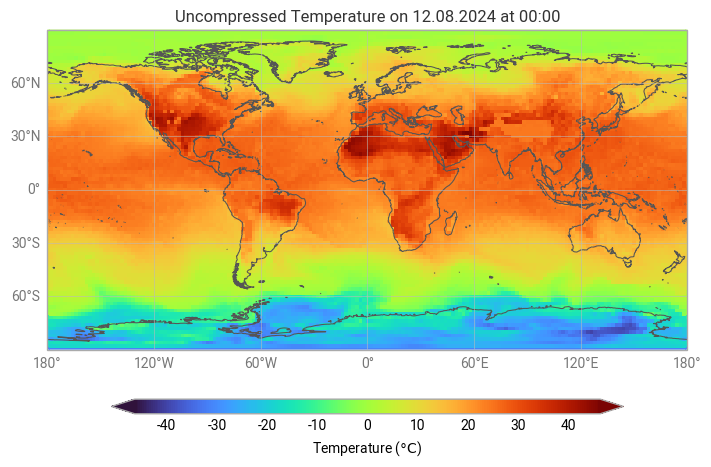

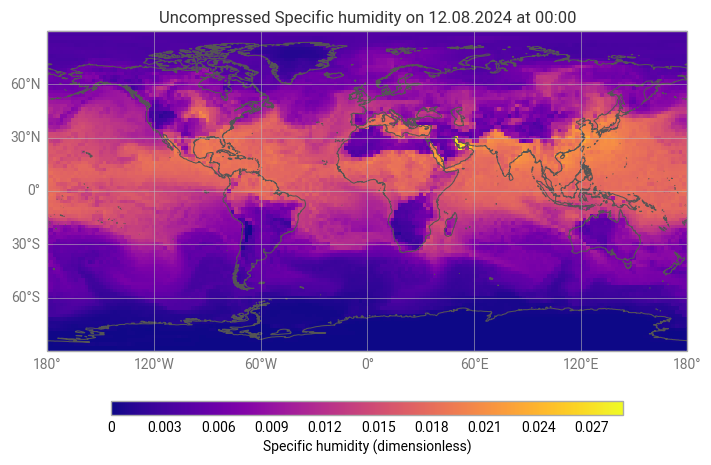

[pyodide]: Loaded 2 new dynamic libraries (186 total for this notebook)


In [9]:
plot_data(ds, title_prefix="Uncompressed ")

## Comparing several different compression methods

### Run a Linear Quantization compressor

One of the codecs included in `fcbench.codecs` is the lossy `LinearQuantize` codec that rescales real-valued data from $[min; max]$ to the integer range $[0; 2^b - 1]$. Here, $b$ is the number of bit precision you want to keep. The compressor outputs an array of values of the smallest unsigned integer type that can represent values of $b$ bits, e.g. `u8`, `u16`, `u32`, or `u64`. If $b$ is not one of these powers of two, a lossless integer compressor can be added to further compress the data.

After you have finished using a compressor, it is important to overwrite or delete it to allow its resources to be reused.

In [10]:
ds_linquant = {}
stats_linquant = {}

for name, da in ds.items():
    linquant_compressor = [
        fcbench.codecs.LinearQuantize(bits=4, dtype=str(da.dtype)),
        fcbench.codecs.Zlib(level=4),
    ]

    stats_linquant[name] = []
    ds_linquant[name] = fcbench.compressor.compress_decompress(
        da, linquant_compressor, measurements=stats_linquant[name],
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(linquant_compressor, stats_linquant[name]))
    
linquant_compressor = str(linquant_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"LinearQuantize(dtype='f64', bits=4)",7.99,0.05,0.33,6.3,1.0
Zlib(level=4),6.42,0.02,0.04,28.1,6.3


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"LinearQuantize(dtype='f64', bits=4)",7.99,0.09,0.31,6.3,1.0
Zlib(level=4),5.03,0.02,0.05,32.1,7.1


When we plot the compressed data, we can see that it has indeed been quantized to $2^4 = 16$ values (per data chunk).

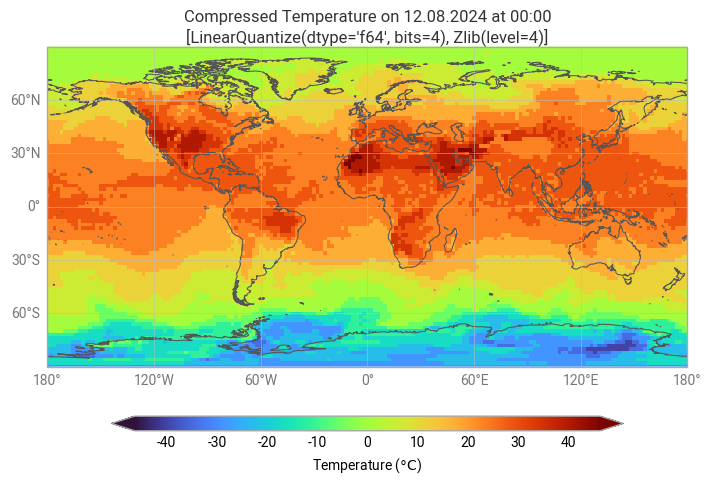

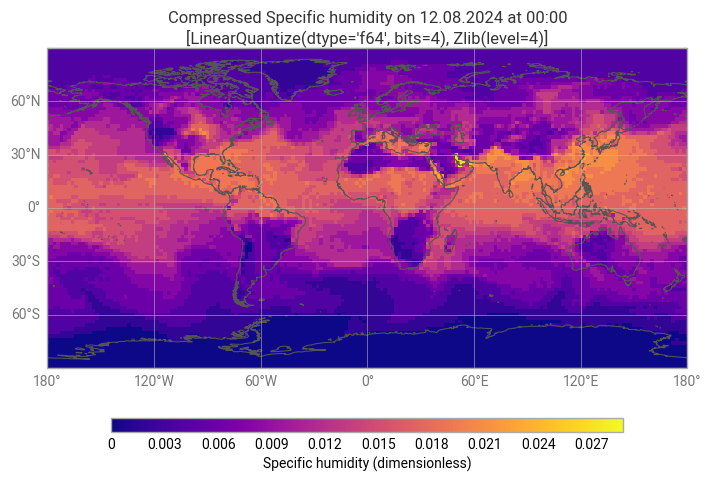

In [11]:
plot_data(
    ds_linquant, title_prefix="Compressed ",
    title_postfix=f"\n{linquant_compressor}",
)

## Plot the Linear Quantization compression error

The following is a helper function to compute the different relative errors.

In [12]:
def compute_relative_errors(da_compressed, da):
    da_error = da_compressed - da

    norm_L1_error = np.abs(da_error).sum().values
    norm_L2_error = np.sqrt((da_error**2).sum().values)
    norm_Linf_error = np.abs(da_error).max().values

    norm_L1_original = np.abs(da).sum().values
    norm_L2_original = np.sqrt((da**2).sum().values)
    norm_Linf_original = np.abs(da).max().values

    relative_error_L1 = norm_L1_error / norm_L1_original
    relative_error_L2 = norm_L2_error / norm_L2_original
    relative_error_Linf = norm_Linf_error / norm_Linf_original

    return {
        "Relative_Error_L1": relative_error_L1,
        "Relative_Error_L2": relative_error_L2,
        "Relative_Error_Linf": relative_error_Linf,
    }

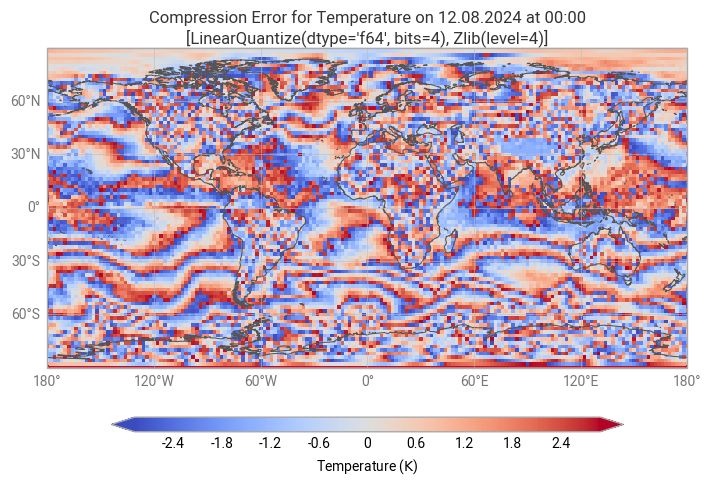

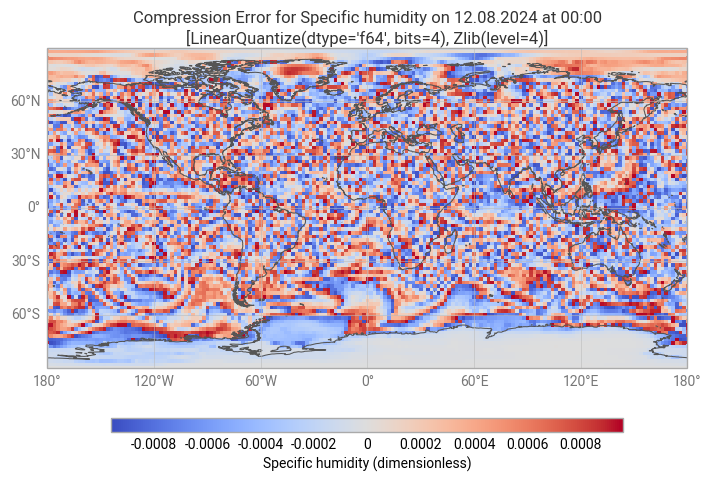

In [13]:
ds_linquant_error = {}
errors_linquant = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_linquant_error[name] = ds_linquant[name] - da
    errors_linquant[name] = compute_relative_errors(ds_linquant[name], da)

plot_data(
    ds_linquant_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{linquant_compressor}", error=True,
)

## Run the BitRound compressor

Bit rounding is a lossy in-place codec that removes false information from the least significant bits of the mantissa of a floating-point number. Measurement and simulation data often produces high precision numbers even though most of the trailing digits are made up of noise and uncertainty. The compression of such data can be aided by setting these bits to a constant value, which a downstream general-purpose compressor can then take advantage of. For bit rounding, the exessive bits are removed by rounding, though other approaches such as zeroing (bit shaving) or alternating between zeroing and setting to all-ones (bit grooming) exist as well.

The BitRound compressor is configured by the number of bits in the mantissa to keep, `keepbits`.

You can find out more about bit rounding, shaving, and grooming in the following publications:

> Caron, J. (2014). *Compression by bit shaving*. Available from: <http://www.unidata.ucar.edu/blogs/developer/entry/compression_by_bit_shaving> [Accessed: 02.10.2024].

> Klöwer, M., Razinger, M., Dominguez, J. J., Düben, P. D., & Palmer, T. N. (2021). Compressing atmospheric data into its real information content. *Nature Computational Science*. 1(11). pp. 713-724. Available from: [doi:10.1038/s43588-021-00156-2](https://doi.org/10.1038/s43588-021-00156-2).

> Zender, C. S. (2016). Bit grooming: statistically accurate precision-preserving quantization with compression, evaluated in the netcdf operators (nco,550 v4.4.8+). *Geoscientific Model Development*. 9(9). pp. 3199-3211. Available from: [doi:10.5194/gmd-9-3199-2016](https://doi.org/10.5194/gmd-9-3199-2016).

In [14]:
ds_bitround = {}
stats_bitround = {}

bitround_compressor = [
    fcbench.codecs.BitRound(keepbits=6),
    fcbench.codecs.Zlib(level=9),
]

for name, da in ds.items():
    stats_bitround[name] = []
    ds_bitround[name] = fcbench.compressor.compress_decompress(
        da, bitround_compressor, measurements=stats_bitround[name],
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(bitround_compressor, stats_bitround[name]))

bitround_compressor = str(bitround_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
BitRound(keepbits=6),1.00,0.25,0.41,0.1,0.0
Zlib(level=9),30.43,0.02,0.21,60.9,2.2


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
BitRound(keepbits=6),1.00,0.28,0.55,0.1,0.0
Zlib(level=9),6.37,0.00,0.13,291.3,5.0


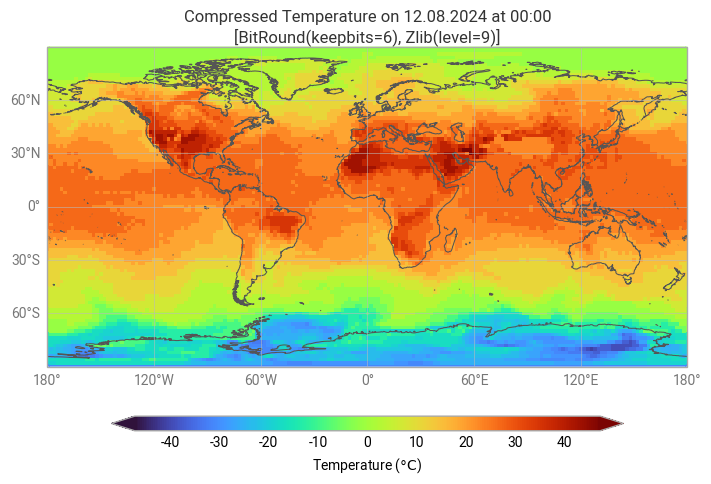

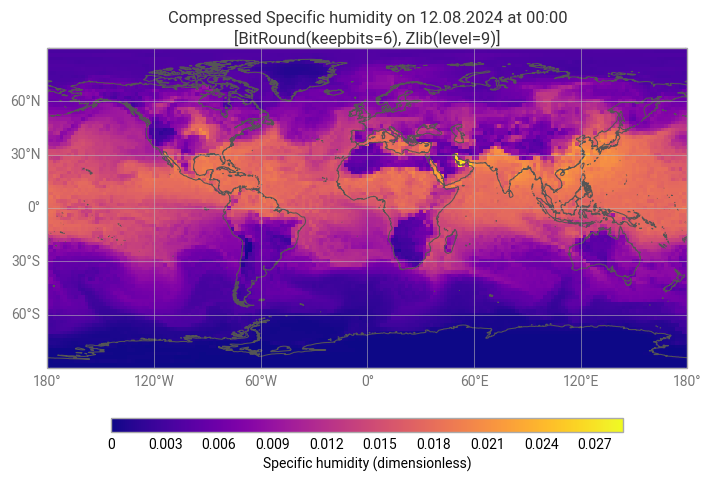

In [15]:
plot_data(
    ds_bitround, title_prefix="Compressed ",
    title_postfix=f"\n{bitround_compressor}",
)

## Plot the BitRound compression error

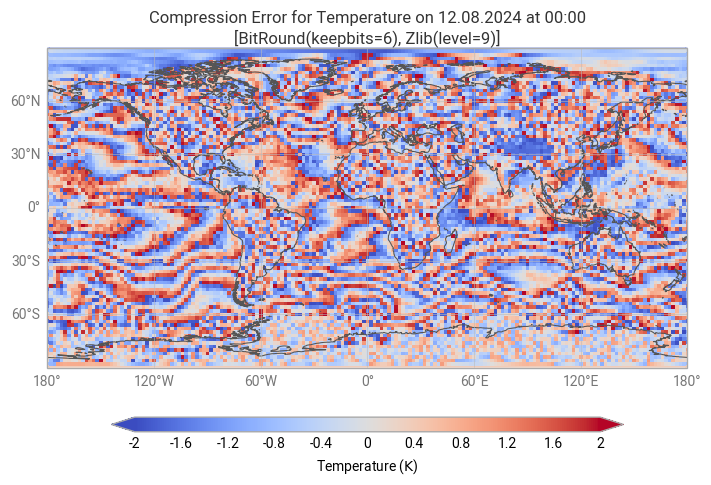

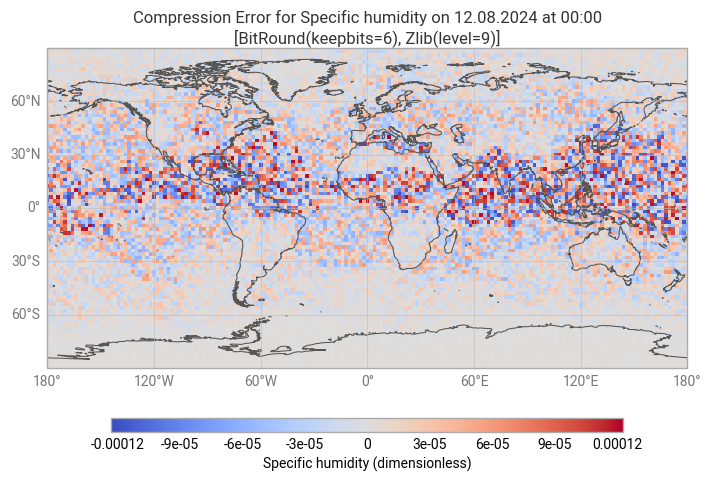

In [16]:
ds_bitround_error = {}
errors_bitround = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_bitround_error[name] = ds_bitround[name] - da
    errors_bitround[name] = compute_relative_errors(ds_bitround[name], da)

plot_data(
    ds_bitround_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{bitround_compressor}", error=True,
)

## Run the transform-based ZFP compressor

ZFP is a lossy transform-based compressor that compresses multidimensional data in $4^d$ chunks where $d$ is the dimensionality of the data. All values in the chunk are decorrelated and then transformed into a binary plane embedding that is roughly ordered by importance. The resulting per-chunk bitstream can be truncated to satisfy a user-provided compression target, e.g. a fixed number of bits, a bitplane precision, or an absolute error tolerance.

You can find out more about the ZFP compressor in its [documentation](https://zfp.readthedocs.io/en/latest/index.html) and the following two publications:

> Diffenderfer, J. et *al*. (2019). Error Analysis of ZFP Compression for Floating-Point Data. *SIAM Journal on Scientific Computing*. 41(3). pp. A1867-A1898. Available from: [doi:10.1137/18M1168832](https://doi.org/10.1137/18M1168832).

> Lindstrom, P. (2014). Fixed-Rate Compressed Floating-Point Arrays. *IEEE Transactions on Visualization and Computer Graphics*. 20(2). pp. 2674-2683. Available from: [doi:10.1109/TVCG.2014.2346458](https://doi.org/10.1109/TVCG.2014.2346458).

In [17]:
ds_zfp = {}
stats_zfp = {}

zfp_compressor = [
    fcbench.codecs.Asinh(linear_width=1.0),
    fcbench.codecs.Zfp(mode="fixed-accuracy", tolerance=1e-3),
]

for name, da in ds.items():
    stats_zfp[name] = []
    ds_zfp[name] = fcbench.compressor.compress_decompress(
        da, zfp_compressor, measurements=stats_zfp[name],
    )
    print(f"{da.long_name}" + ":")
    display(
        utils.format_compress_stats(zfp_compressor, stats_zfp[name])
    )

zfp_compressor = str(zfp_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
Asinh(linear_width=1.0),1.00,0.09,0.12,2.8,4.5
"Zfp(mode='fixed-accuracy', tolerance=0.001)",2.66,0.08,0.09,9.4,8.6


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
Asinh(linear_width=1.0),1.00,0.11,0.19,2.8,3.5
"Zfp(mode='fixed-accuracy', tolerance=0.001)",4.92,0.12,0.13,6.9,5.8


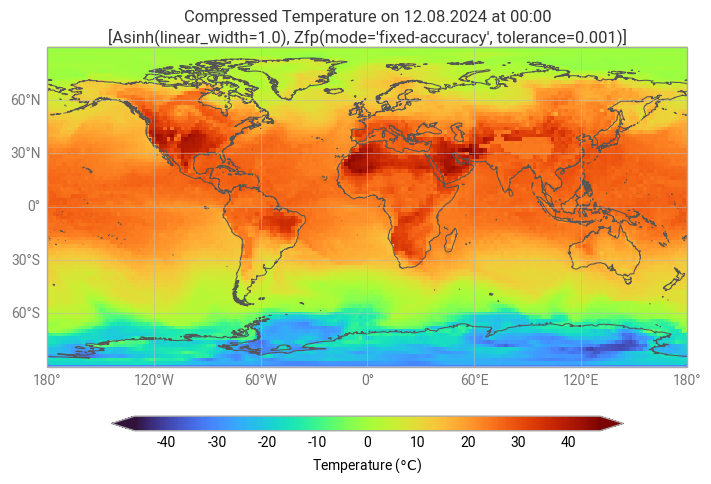

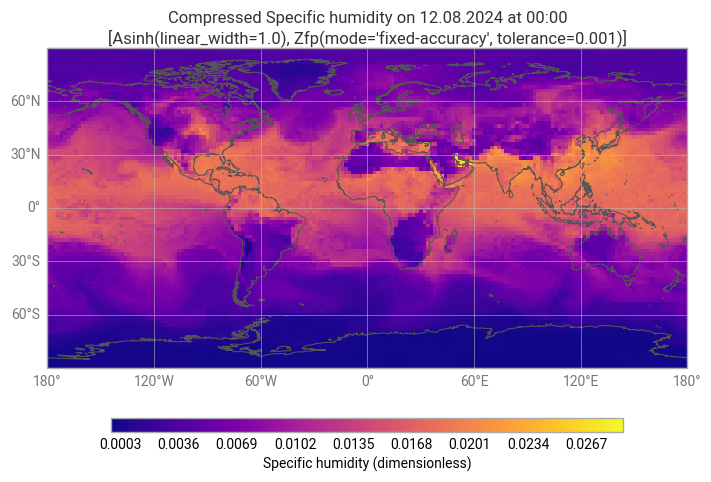

In [18]:
plot_data(
    ds_zfp, title_prefix="Compressed ",
    title_postfix=f"\n{zfp_compressor}",
)

## Plot the ZFP compression error

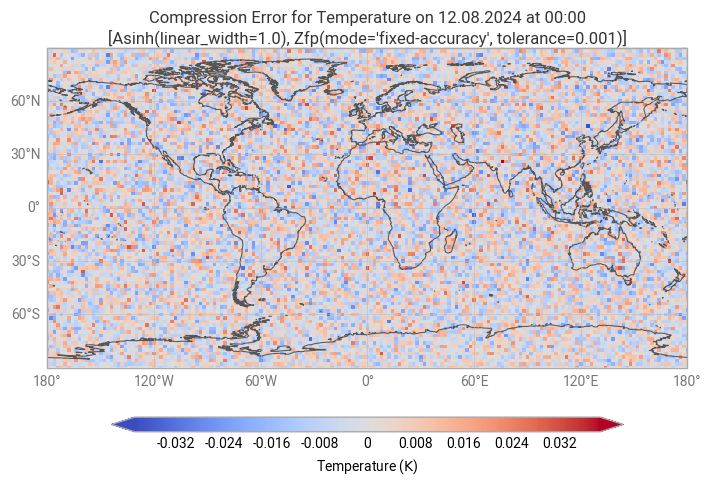

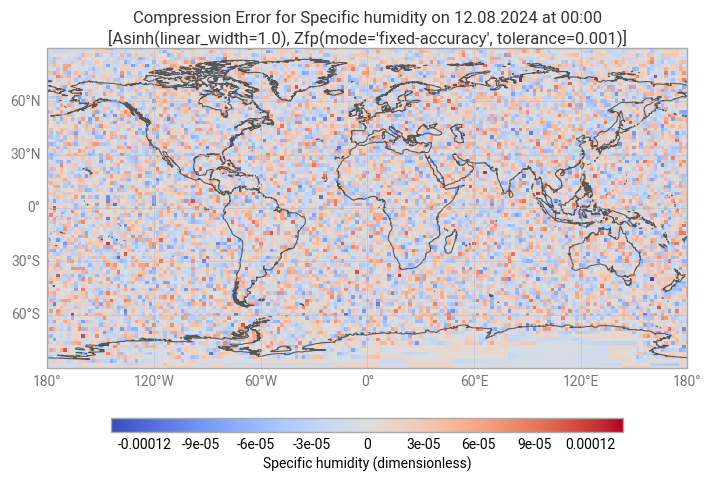

In [19]:
ds_zfp_error = {}
errors_zfp = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_zfp_error[name] = ds_zfp[name] - da
    errors_zfp[name] = compute_relative_errors(ds_zfp[name], da)

plot_data(
    ds_zfp_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{zfp_compressor}", error=True,
)

## Run the prediction-based SZ3 compressor

SZ3 is a lossy prediction-based compressor that compresses multidimensional data by predicting the next value based on an indentified pattern. The quantized prediction errors are stored alongside the pattern. SZ3 is a modular compression pipeline that combines a data preprocessor, predictor, quantizer, encoder, and lossless compressor. The compression error can be bounded with absolute, relative, and PWR error bounds.

You can find out more about the SZ3 compressor in the following publications:

> Liang, X. et *al*. (2023). SZ3: A modular framework for composing prediction-based error-bounded lossy compressors. *IEEE Transactions on Big Data*. 9(2). pp. 485-498. Available from: [doi:10.1109/TBDATA.2022.3201176](https://doi.org/10.1109/TBDATA.2022.3201176).

> Zhao, K. et *al*. (2021). Optimizing Error-Bounded Lossy Compression for Scientiﬁc Data by Dynamic Spline Interpolation. In: *Proceeding of the 37th IEEE International Conference on Data Engineering*. pp. 1643-1654. Available from: [doi:10.1109/ICDE51399.2021.00145](https://doi.org/10.1109/ICDE51399.2021.00145).

> Liang, X. et *al*. (2018). Error-Controlled Lossy Compression Optimized for High Compression Ratios of Scientific Datasets. *IEEE International Conference on Big Data*. pp. 438-447. Available from: [doi:10.1109/BigData.2018.8622520](https://doi.org/10.1109/BigData.2018.8622520).

In [20]:
ds_sz3 = {}
stats_sz3 = {}

sz3_compressor = [fcbench.codecs.Sz3(eb_mode="rel", eb_rel=1e-3)]

for name, da in ds.items():
    stats_sz3[name] = []
    ds_sz3[name] = fcbench.compressor.compress_decompress(
        da, sz3_compressor, measurements=stats_sz3[name],
    )
    print(f"{da.long_name}" + ":")
    display(utils.format_compress_stats(sz3_compressor, stats_sz3[name]))

sz3_compressor = str(sz3_compressor)

Temperature:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"Sz3(eb_mode='rel', eb_rel=0.001)",10.89,0.07,0.17,7.7,2.6


Specific humidity:


,compression ratio [raw B / enc B],encode throughput [raw GB/s],decode throughput [raw GB/s],encode instructions [#/B],decode instructions [#/B]
Codec,,,,,
"Sz3(eb_mode='rel', eb_rel=0.001)",9.39,0.09,0.19,7.9,2.8


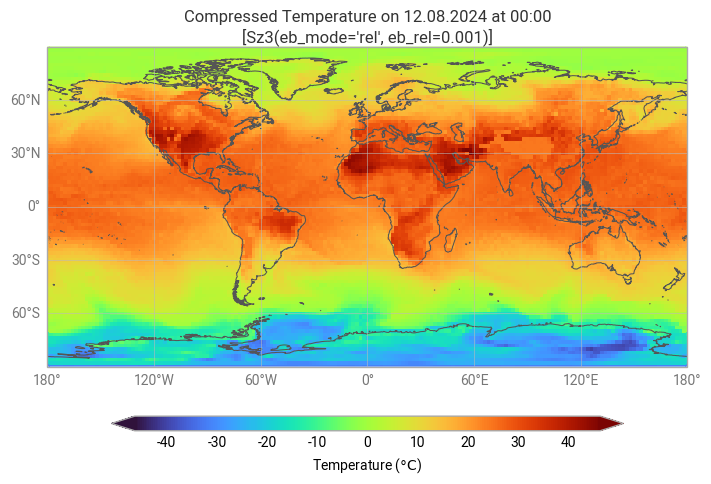

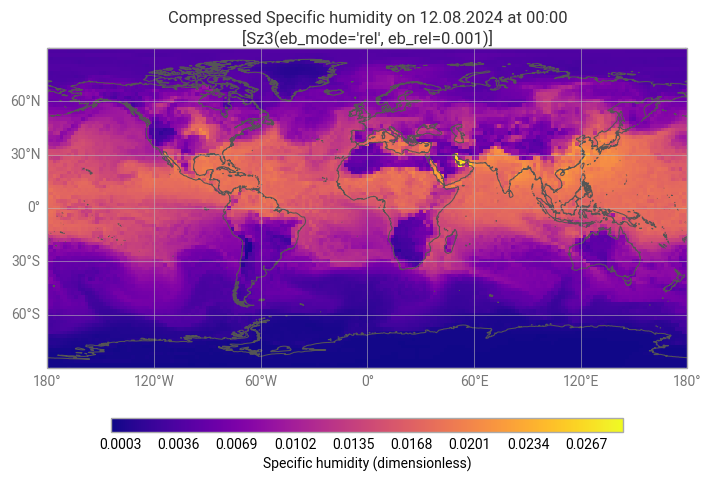

In [21]:
plot_data(
    ds_sz3, title_prefix="Compressed ",
    title_postfix=f"\n{sz3_compressor}",
)

## Plot the SZ3 compression error

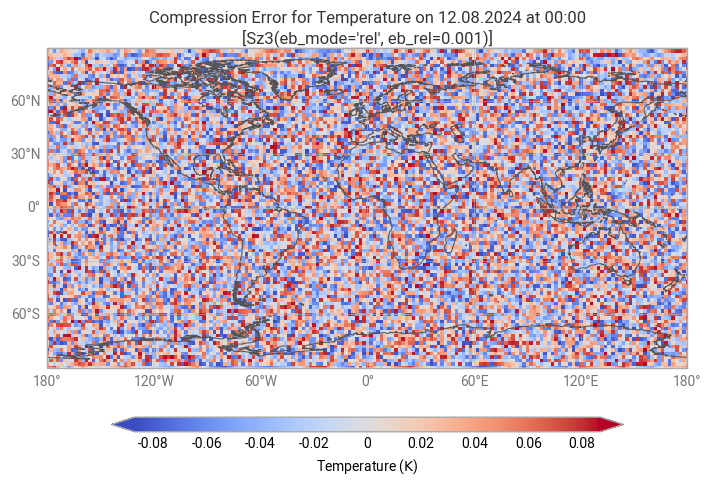

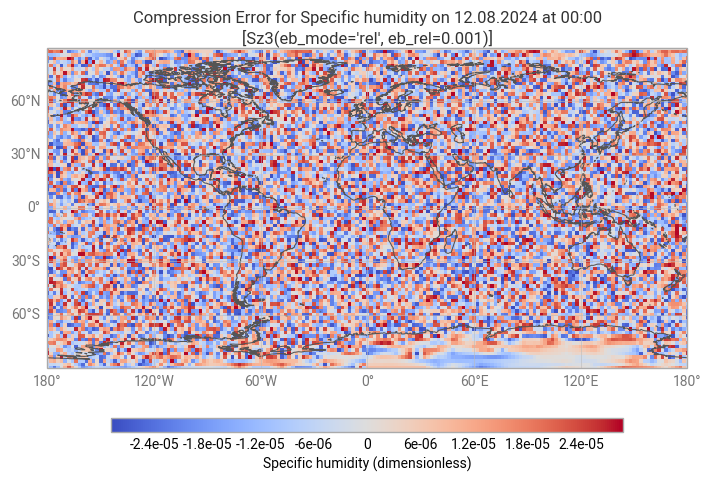

In [22]:
ds_sz3_error = {}
errors_sz3 = {}

for name, da in ds.items():
    with xr.set_options(keep_attrs=True):
        ds_sz3_error[name] = ds_sz3[name] - da
    errors_sz3[name] = compute_relative_errors(ds_sz3[name], da)

plot_data(
    ds_sz3_error, title_prefix="Compression Error for ",
    title_postfix=f"\n{sz3_compressor}", error=True,
)

## Overview 

Here you get an overview table showing the used compressors, compression factors and resulting $L^1$, $L^2$ and $L^\infty$ errors.

In [23]:
data = []

compressors = {
    linquant_compressor: (errors_linquant, stats_linquant),
    bitround_compressor: (errors_bitround, stats_bitround),
    zfp_compressor: (errors_zfp, stats_zfp),
    sz3_compressor: (errors_sz3, stats_sz3),
}

for compressor_name, (errors, stats) in compressors.items():
    for variable, error_data in errors.items():
        row = {
            "Compressor": compressor_name,
            "Variable": variable,
            "Compression Ratio [raw B / enc B]": round(
                stats[variable][0].decoded_bytes / stats[variable][-1].encoded_bytes,
                2,
            ),
            "L1 Error": error_data.get("Relative_Error_L1", None),
            "L2 Error": error_data.get("Relative_Error_L2", None),
            "Linf Error": error_data.get("Relative_Error_Linf", None),
            "Encode Instructions [# / raw B]": round(
                sum(s.encode_instructions for s in stats[variable])
                / stats[variable][0].decoded_bytes,
                1,
            ),
            "Decode Instructions [# / raw B]": round(
                sum(s.decode_instructions for s in stats[variable])
                / stats[variable][0].decoded_bytes,
                1,
            ),
            "Encode Throughput [raw GB / s]": round(
                1e-9
                * stats[variable][0].decoded_bytes
                / sum(
                    s.encode_timing.secs + s.encode_timing.nanos * 1e-9
                    for s in stats[variable]
                ),
                2,
            ),
            "Decode Throughput [raw GB / s]": round(
                1e-9
                * stats[variable][0].decoded_bytes
                / sum(
                    s.decode_timing.secs + s.decode_timing.nanos * 1e-9
                    for s in stats[variable]
                ),
                2,
            ),
        }
        data.append(row)


df = pd.DataFrame(data).set_index(["Compressor", "Variable"])
df

Compression Ratio [raw B / enc B]  \
Compressor                                         Variable                                      
[LinearQuantize(dtype='f64', bits=4), Zlib(leve... t                                     51.27   
                                                   q                                     40.21   
[BitRound(keepbits=6), Zlib(level=9)]              t                                     30.43   
                                                   q                                      6.37   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t                                      2.66   
                                                   q                                      4.92   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t                                     10.89   
                                                   q                                      9.39   

                                                             L1 Error  \
Compressor                                         Variable             
[LinearQuantize(dtype='f64', bits=4), Zlib(leve... t         0.005129   
                                                   q         0.052013   
[BitRound(keepbits=6), Zlib(level=9)]              t         0.003308   
                                                   q         0.002944   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t         0.000029   
                                                   q         0.003348   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t         0.000146   
                                                   q         0.001642   

                                                             L2 Error  \
Compressor                                         Variable             
[LinearQuantize(dtype='f64', bits=4), Zlib(leve... t         0.005923   
                                                   q         0.050810   
[BitRound(keepbits=6), Zlib(level=9)]              t         0.003879   
                                                   q         0.003563   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t         0.000036   
                                                   q         0.003411   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t         0.000170   
                                                   q         0.001558   

                                                             Linf Error  \
Compressor                                         Variable               
[LinearQuantize(dtype='f64', bits=4), Zlib(leve... t           0.009015   
                                                   q           0.033329   
[BitRound(keepbits=6), Zlib(level=9)]              t           0.006264   
                                                   q           0.004255   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t           0.000121   
                                                   q           0.004803   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t           0.000270   
                                                   q           0.001000   

                                                             Encode Instructions [# / raw B]  \
Compressor                                         Variable                                    
[LinearQuantize(dtype='f64', bits=4), Zlib(leve... t                                     9.8   
                                                   q                                    10.3   
[BitRound(keepbits=6), Zlib(level=9)]              t                                    61.0   
                                                   q                                   291.4   
[Asinh(linear_width=1.0), Zfp(mode='fixed-accur... t                                    12.1   
                                                   q                                     9.7   
[Sz3(eb_mode='rel', eb_rel=0.001)]                 t                                     7.7   
   